In [170]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
from glob import glob
from scipy import optimize
from hampel import hampel

# %matplotlib notebook
plt.style.use('dark_background')
color = ['#8dd3c7','#feffb3','#bfbbd9','#fa8174','#81b1d2','#fdb462','#b3de69','#bc82bd','#ccebc4','#ffed6f']




In [171]:
files = glob('**/*.dat', recursive=True)
path = '/Users/wendy/Desktop/111/GMA/Wendy&Yilun/wendy have fun/01_28_2022_17_09_05/final_aved_Data3min.csv'


In [172]:
file_Mn = [f for f in files if ("Mn" in f and 'Mn_' not in f)]
file_other = [f for f in files if "Mn" not in f]

In [173]:
def cutdat(data,lowlim,highlim):
    data_x = data['freq'].values
    data_y = data['vals'].values
    data_y = data_y[(data_x > low_lim) & (data_x < up_lim)]
    data_x = data_x[(data_x > low_lim) & (data_x < up_lim)]
    return(data_x,data_y)

In [603]:
background = pd.read_csv(path)
def subtract(data,time,background = background,filenumber = 1):
    freq = data[0].values
    data_sub = data[1].values-background['values'].values/3*(time/60)
    err = (np.sqrt(data[1].values) + (time/180)**2*background['std'])/np.sqrt(filenumber)
    result = pd.DataFrame([])
    result['freq'] = freq
    result['vals'] = data_sub
    result['std'] = err
    
    return result

In [604]:
hampel

<function hampel.hampel(ts, window_size=5, n=3)>

In [706]:
def exp(x,ave,sigma,amp,c,b):
    return(amp*np.exp(-(x-ave)**2/(2*sigma**2))+c*x+b)
def exp1(x,ave,sigma,amp,c,b,e):
    return(amp*np.exp(-((x-ave)**2-e*x)/(2*sigma**2))+c*x+b)
def mt_fit(data_x,data_y,err_x ,err_y,up_lim,low_lim,N,p0=[1.28,0.02,25,0,10],z = 0):

    
#     data_y = hampel(pd.Series(data_y),window_size = 20)
    data_y = data_y[(data_x > low_lim) & (data_x < up_lim)]
    
    if type(err_x) is not int:
        err_x = err_x[(data_x > low_lim) & (data_x < up_lim)]
    if type(err_y) is not int:
        err_y = err_y[(data_x > low_lim) & (data_x < up_lim)]
    data_x = data_x[(data_x > low_lim) & (data_x < up_lim)]
    if z:
        func = exp1
        zz = []
    else:
        func = exp
    ave = []
    sigma = []
    amp = []
    c = []
    b = []
    dd = []
    for i in range(N):
#         data_xe = np.array(data_x)+np.random.normal(0,err_x)
#         data_ye = np.array(data_y)+np.random.normal(0,err_y)

        data_xe = np.random.normal(data_x,err_x)
        data_ye = np.random.normal(data_y,err_y)

        paras, _ = optimize.curve_fit(func, data_xe, data_ye,p0 = p0)
        ave += [paras[0]]
#         print(ave)
        sigma += [paras[1]]
        amp += [paras[2]]
        c += [paras[3]]
        b += [paras[4]]
        if z:
            zz +=[paras[5]]
#         print(_[0])
#         dd += [np.trace(_[0])]
#         dd1 += [np.trace(_[2])]
        
        
#         print(dd)
        
    
#     fig, ax = plt.subplots(figsize = (16,12))

#     ax.scatter(data_x, data_y,s = 0.3)
#     ax.plot(data_x,exp(data_x,*paras), )
#     plt.plot()
    ave_a = np.mean(ave)
    sigma_a = np.mean(sigma)
    amp_a = np.mean(amp)
    c_a = np.mean(c)
    b_a = np.mean(b)
    paras = [ave_a,sigma_a,amp_a,c_a,b_a]
    
    
    ave_err = (np.std(ave))
    sigma_err = np.std(sigma)
    amp_err = (np.std(amp))
    c_err = np.std(c)
    b_err = np.std(b)
    
    
    obs = data_y
    model = exp(data_x,*paras)
    error = err_y
    def chisquared(obs, model, error):
        return np.average(((obs - model) / error)**2)
    
    chi = chisquared(obs,model,error)
    errs = [ave_err,sigma_err,amp_err,c_err,b_err,chi]
    
    plt.scatter(obs, error)
    plt.scatter(obs, obs-model)
    if z:
        return([paras+[np.average(zz)]],errs)
    return (paras, errs)

## Mn 10min spectrum

In [606]:
#first read data and sum/average it 
data = pd.read_csv(file_Mn[0],skiprows = 2,sep="\s+", header = None,usecols = [0,1])
vals = np.empty(len(data[1]))
vals.fill(0)
for f in file_Mn:
    data = pd.read_csv(f,skiprows = 2,sep="\s+", header = None,usecols = [0,1])
    vals += np.array(data[1].values,dtype = int)/len(file_Mn)
data[1] = vals

In [607]:
#then manipulate data to subtract from the background
dat_sub_Mn = subtract(data,600,filenumber = len(file_Mn))

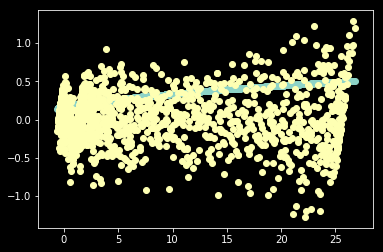

In [608]:
#plot data and find the optimal range
up_lim = 1.4
low_lim = 1.1
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Mn


Mn11_paras, Mn11_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,100,p0 = [1.28,0.02,25,0,10])

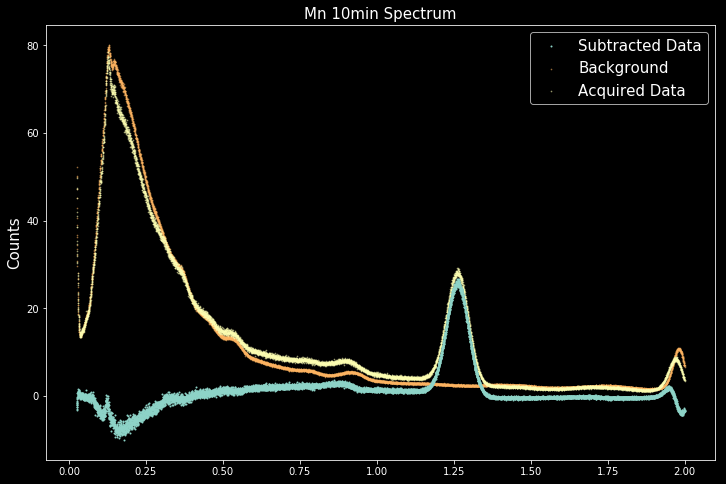

In [609]:
def plot_bg(dat_sub_Mn, data,title,t):    
    fig,ax = plt.subplots(figsize = (12,8))
    ax.scatter(dat_sub_Mn['freq'],dat_sub_Mn['vals'],s = 1,color = color[0],label = 'Subtracted Data',zorder = 101)
    ax.scatter(background['freq'],background['values']/3*t,s = 0.5,color = color[5],label = 'Background',alpha = 0.5)
    ax.scatter(data[0],data[1],s = 0.5,color = color[1],label = 'Acquired Data',alpha = 0.5)

    ax.legend(fontsize = 15)
    ax.set_ylabel('Counts',fontsize = 15)
    ax.set_title(title,fontsize = 15)
    plt.show()
# ax.grid(zorder = -1,aplha = 0.5)
# ax.plot(dat_sub_Mn['freq'],exp(dat_sub_Mn['freq'],*Mn11_paras),color = color[1])
plot_bg(dat_sub_Mn, data,'Mn 10min Spectrum',10)

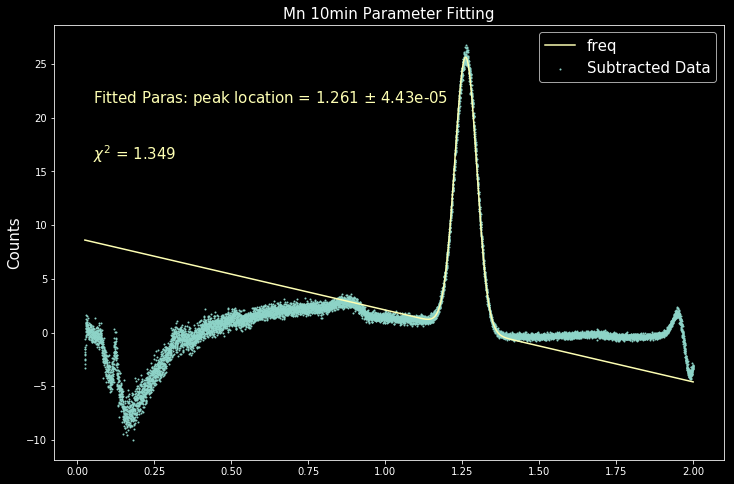

In [610]:
fig,ax = plt.subplots(figsize = (12,8))
ax.scatter(dat_sub_Mn['freq'],dat_sub_Mn['vals'],s = 1,color = color[0],label = 'Subtracted Data')
ax.plot(dat_sub_Mn['freq'],exp(dat_sub_Mn['freq'],*Mn11_paras),color = color[1])
# ax.scatter(background['freq'],background['values']/3*10,s = 1,color = color[5],label = 'Background')
# ax.scatter(data[0],data[1],s = 1,color = color[1],label = 'Acquired Data')
# def chisquared(obs, model, error):
#     return sum(((obs - model) / error)**2)

# ax.vlines(low_lim,0,30)
ax.text(0.05,0.8*max(dat_sub_Mn['vals']),r'Fitted Paras: peak location = {para:.4g} $\pm$ {err:.3g}'.format(para = Mn11_paras[0],err = Mn11_errs[0]),color = color[1],fontsize= 15)


ax.text(0.05,0.6*max(dat_sub_Mn['vals']),r'$\chi^2$ = {para:.4g}'.format(para = Mn11_errs[-1]),color = color[1],fontsize= 15)


ax.legend(fontsize = 15)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_title('Mn 10min Parameter Fitting',fontsize = 15)



plt.show()

In [611]:
def plot_fit(dat_sub_Mn, Mn11_paras,Mn11_errs,title):
    fig,ax = plt.subplots(figsize = (12,8))
    ax.scatter(dat_sub_Mn['freq'],dat_sub_Mn['vals'],s = 1,color = color[0],label = 'Subtracted Data')
    ax.plot(dat_sub_Mn['freq'],exp(dat_sub_Mn['freq'],*Mn11_paras),color = color[1],label = 'Fitted Data')
    # ax.scatter(background['freq'],background['values']/3*10,s = 1,color = color[5],label = 'Background')
    # ax.scatter(data[0],data[1],s = 1,color = color[1],label = 'Acquired Data')

    # ax.vlines(low_lim,0,30)
    ax.text(0.05,0.8*max(dat_sub_Mn['vals']),r'Fitted Paras: peak location = {para:.4g} $\pm$ {err:.3g}'.format(para = Mn11_paras[0],err = Mn11_errs[0]),color = color[1],fontsize= 15)

#     obs = np.array(dat_sub_Mn['vals'])
#     model = exp(dat_sub_Mn['freq'],*Mn11_paras).values
#     error = np.array(dat_sub_Mn['std'].values)
#     print(max(error))
#     chi = chisquared(obs,model,error)/float(len(error)-5)
    ax.text(0.05,0.6*max(dat_sub_Mn['vals']),r'$\chi^2$ = {para:.4g}'.format(para = Mn11_errs[-1]),color = color[1],fontsize= 15)


    ax.legend(fontsize = 15)
    ax.set_ylabel('Counts',fontsize = 15)
    ax.set_title(title,fontsize = 15)



    plt.show()

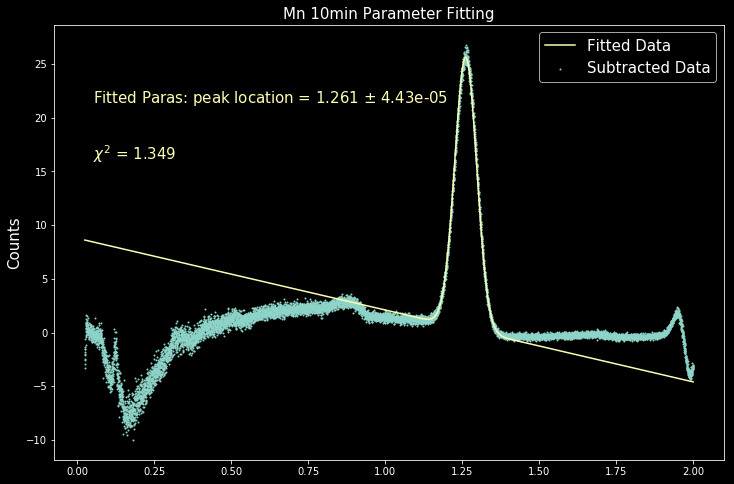

In [612]:
plot_fit(dat_sub_Mn, Mn11_paras,Mn11_errs,'Mn 10min Parameter Fitting')

## Cs 300s spectrum

In [726]:
#first read data and sum/average it 
print(file_other[0])
data = pd.read_csv(file_other[0],skiprows = 2,sep="\s+", header = None,usecols = [0,1])

01_27_2022_16_42_22/Cs_301s.dat


In [727]:
#then manipulate data to subtract from the background
dat_sub_cs300 = subtract(data,300,filenumber = 1)

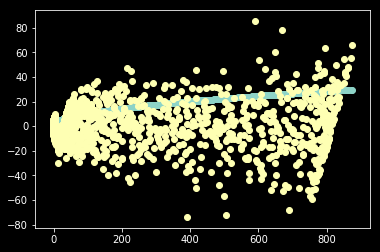

In [743]:
#plot data and find the optimal range
up_lim = 1.2
low_lim = 0.8
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_cs300
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,dat_sub['freq'].values,dat_sub['vals'].values)
Cs11_paras, Cs11_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

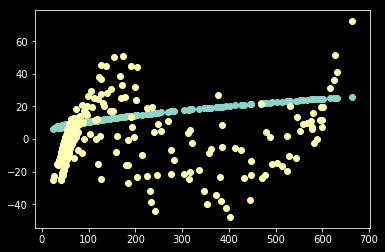

In [742]:
#plot data and find the optimal range
up_lim = 0.08
low_lim = 0
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_cs300
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,dat_sub['freq'].values,dat_sub['vals'].values)
par = [0.055,0.001,550,0.1,0.1]
Cs10_paras, Cs10_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

In [740]:
p0 = [500,0.001,0.055,0,0]

(0, 0.08)

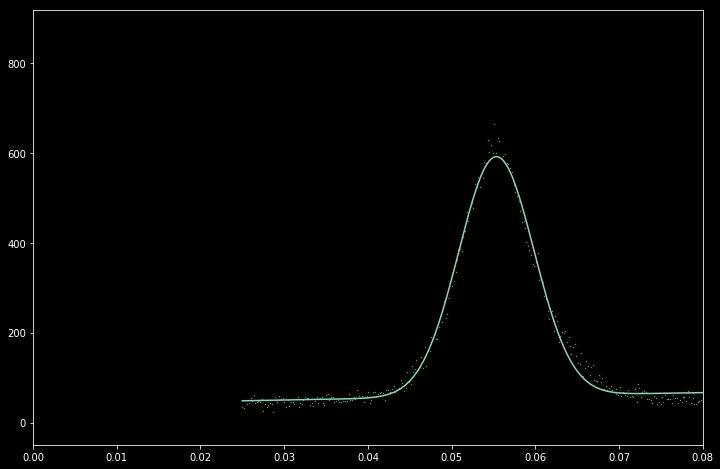

In [741]:
fig,ax = plt.subplots(figsize = (12,8))
ax.scatter(dat_sub_cs300['freq'],dat_sub_cs300['vals'],s = 0.1)
ax.plot(dat_sub_cs300['freq'],exp(dat_sub_cs300['freq'],*Cs11_paras))
ax.set_xlim(low_lim,up_lim)

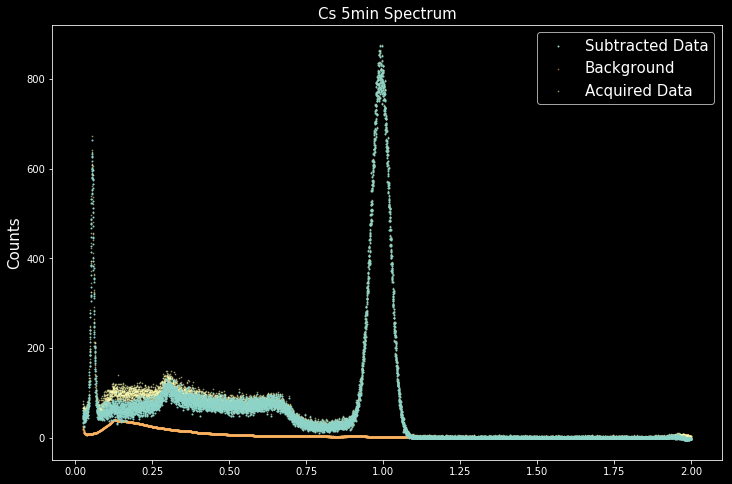

In [584]:
plot_bg(dat_sub_cs300, data,'Cs 5min Spectrum',t = 5)

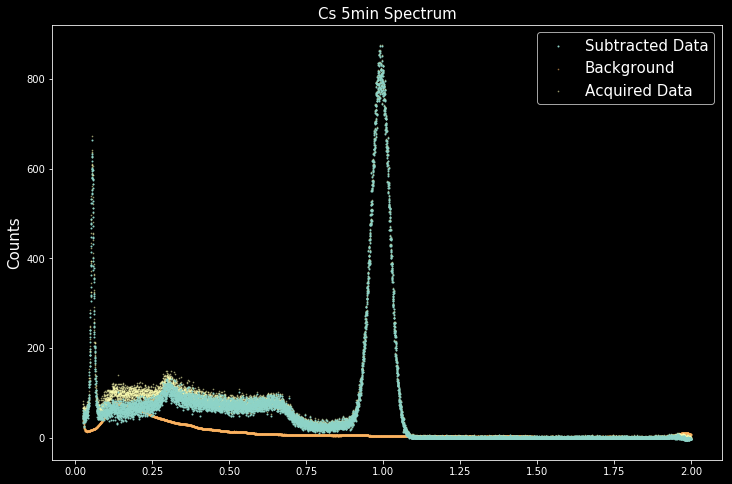

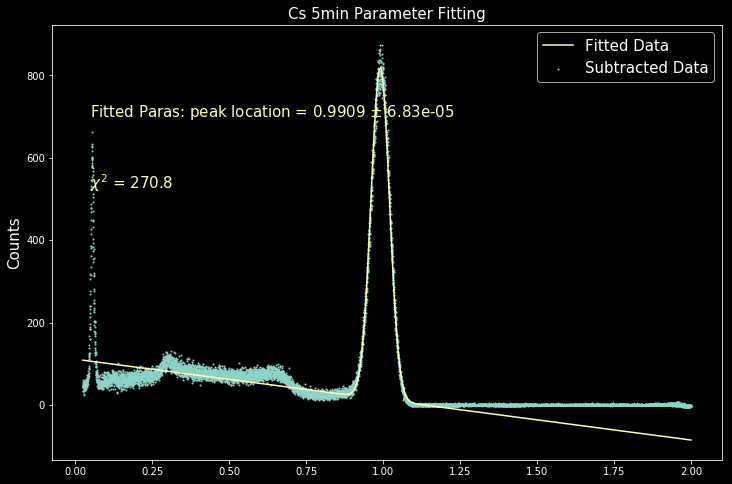

In [585]:
plot_bg(dat_sub_cs300, data,'Cs 5min Spectrum',t = 10)
plot_fit(dat_sub_cs300, Cs11_paras,Cs11_errs,'Cs 5min Parameter Fitting')

In [586]:
np.sqrt(800)

28.284271247461902

## Na 270s spectrum

In [618]:
#first read data and sum/average it 
print(file_other[1])
data = pd.read_csv(file_other[1],skiprows = 2,sep="\s+", header = None,usecols = [0,1])

01_27_2022_16_24_56/Na_270s.dat


In [619]:
#then manipulate data to subtract from the background
dat_sub_Na270 = subtract(data,270,filenumber = 1)

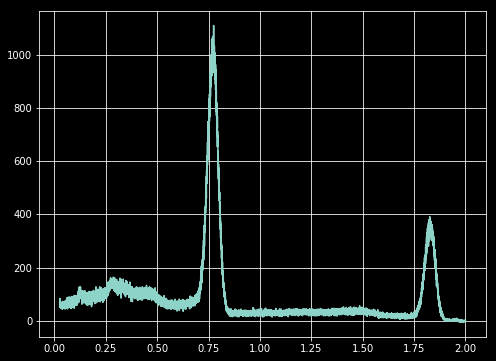

In [620]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(dat_sub_Na270['freq'],dat_sub_Na270['vals'])
ax.grid()

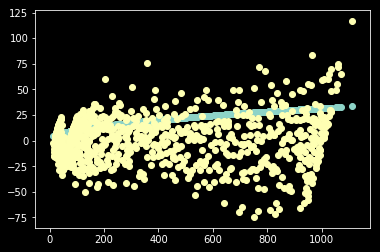

In [621]:
#Peak 1
#plot data and find the optimal range
up_lim = 0.9
low_lim = 0.65
p0 = [0.79,0.01,1000,0,0]
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Na270
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,datx,daty,p0 = p0)
Na11_paras, Na11_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(0.65, 0.9)

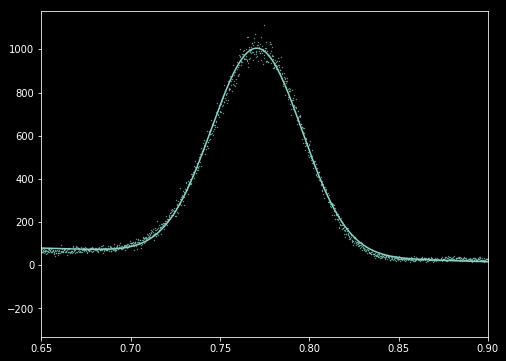

In [622]:
datass = dat_sub_Na270
parass = Na11_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

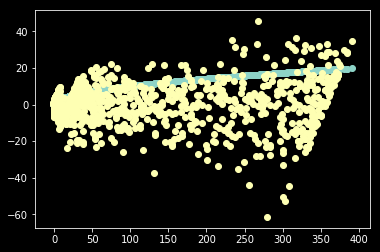

In [635]:
#Peak 2
#plot data and find the optimal range
up_lim = 1.95
low_lim = 1.7
p0 = [1.83,0.01,400,0,0]

#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Na270
par, _ = optimize.curve_fit(exp,dat_sub['freq'].values,dat_sub['vals'].values,p0=p0)
Na12_paras, Na12_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(1.7, 1.95)

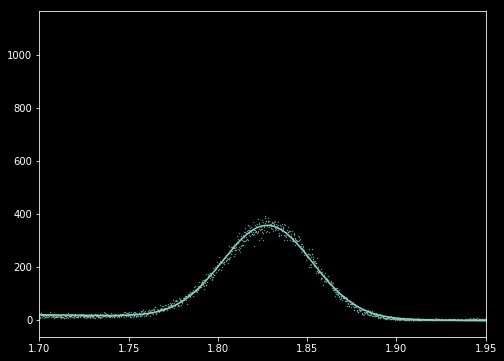

In [636]:
datass = dat_sub_Na270
parass = Na12_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

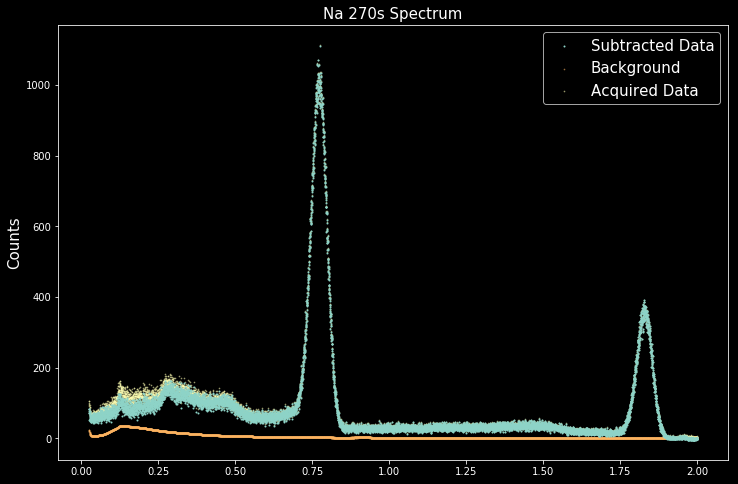

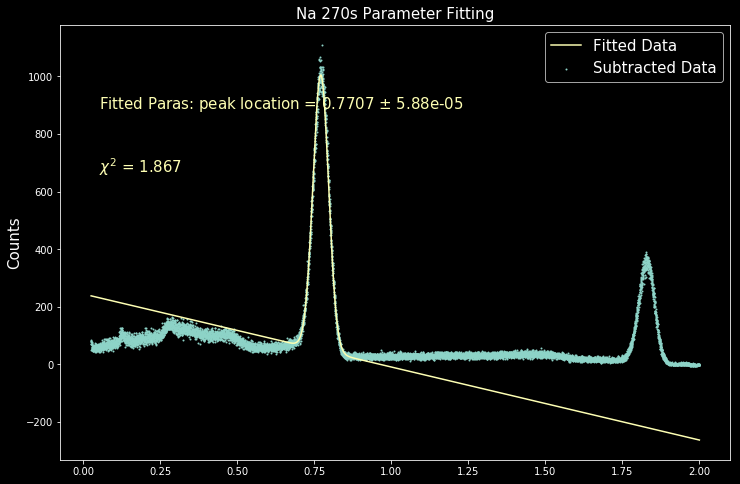

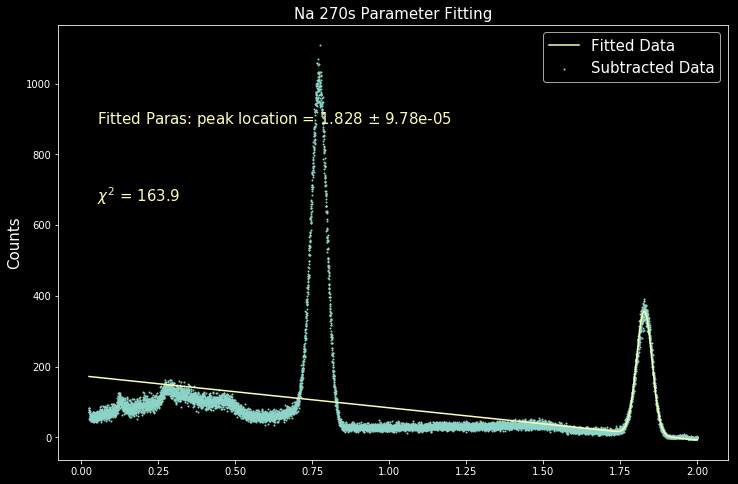

In [626]:
plot_bg(dat_sub_Na270, data,'Na 270s Spectrum',t=270/60)
plot_fit(dat_sub_Na270, Na11_paras,Na11_errs,'Na 270s Parameter Fitting')
plot_fit(dat_sub_Na270, Na12_paras,Na12_errs,'Na 270s Parameter Fitting')

(1.7, 1.95)

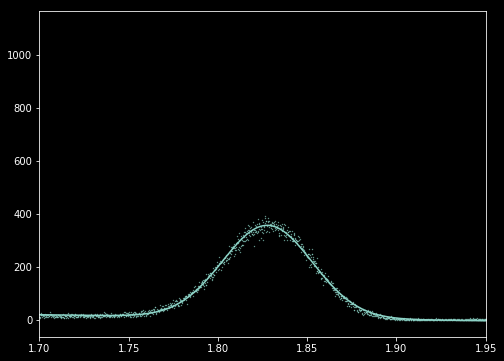

In [594]:
datass = dat_sub_Na270
parass = Na12_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

## Co 286s spectrum

In [716]:
#first read data and sum/average it 
print(file_other[2])
data = pd.read_csv(file_other[2],skiprows = 2,sep="\s+", header = None,usecols = [0,1])

01_27_2022_16_49_34/Co_286s.dat


In [717]:
#then manipulate data to subtract from the background
dat_sub_Co286 = subtract(data,286,filenumber = 1)

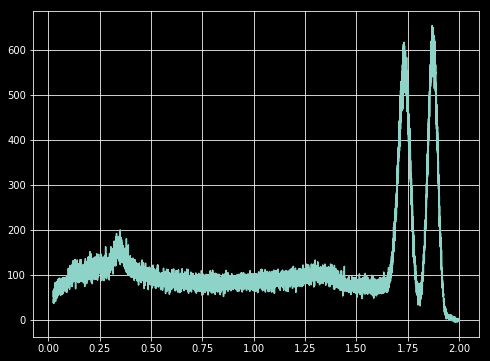

In [718]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(dat_sub_Co286['freq'],dat_sub_Co286['vals'])
ax.grid()

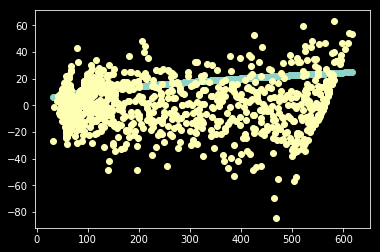

In [719]:
#Peak 1
#plot data and find the optimal range
up_lim = 1.81
low_lim = 1.6
p0 = [1.725,0.01,500,0,0]
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Co286
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,datx,daty,p0 = p0)
Co11_paras, Co11_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(1.6, 1.81)

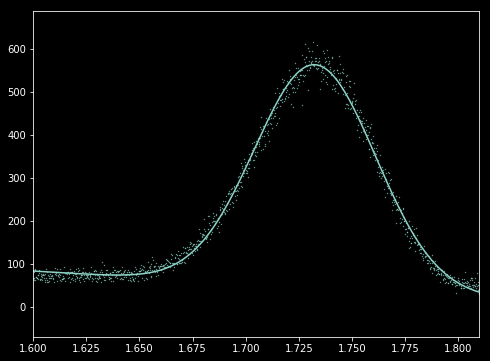

In [720]:
datass = dat_sub_Co286
parass = Co11_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

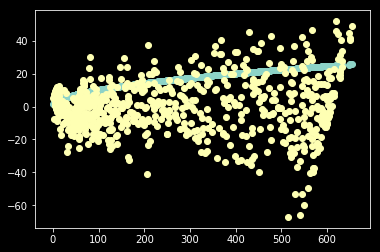

In [721]:
#Peak 2
#plot data and find the optimal range
up_lim = 1.95
low_lim = 1.8
p0 = [1.87,0.01,600,0,0]

#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Co286
par, _ = optimize.curve_fit(exp,dat_sub['freq'].values,dat_sub['vals'].values,p0=p0)
Co12_paras, Co12_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(1.8, 1.95)

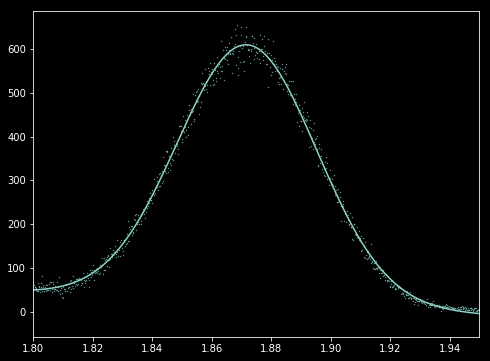

In [722]:
datass = dat_sub_Co286
parass = Co12_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

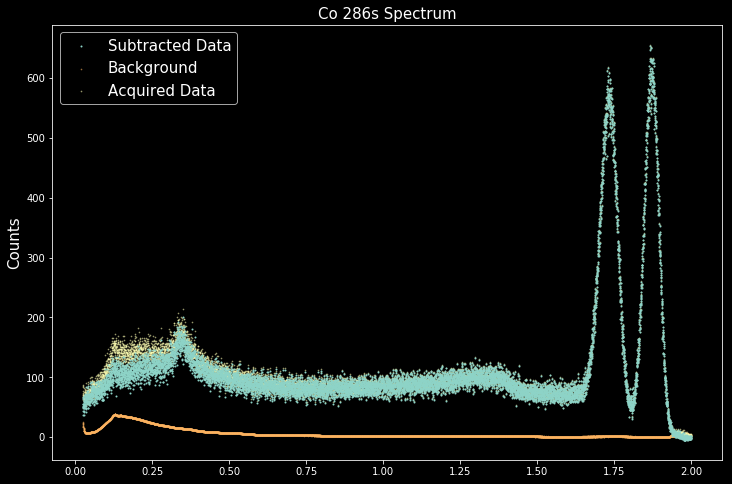

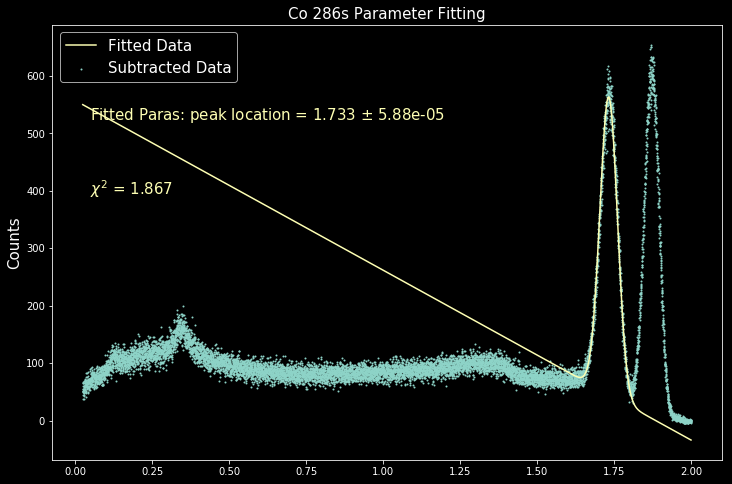

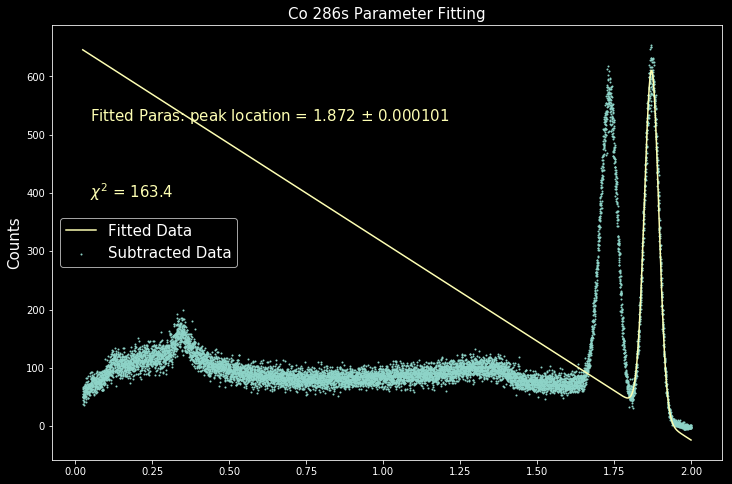

In [725]:
plot_bg(dat_sub_Co286, data,'Co 286s Spectrum',t=286/60)
plot_fit(dat_sub_Co286, Co11_paras, Na11_errs,'Co 286s Parameter Fitting')
plot_fit(dat_sub_Co286, Co12_paras, Na12_errs,'Co 286s Parameter Fitting')

## Na 309s spectrum

In [426]:
#first read data and sum/average it 
print(file_other[3])
data = pd.read_csv(file_other[3],skiprows = 2,sep="\s+", header = None,usecols = [0,1])

01_27_2022_16_30_09/Na_309s.dat


In [427]:
#then manipulate data to subtract from the background
dat_sub_Na309 = subtract(data,309,filenumber = 1)

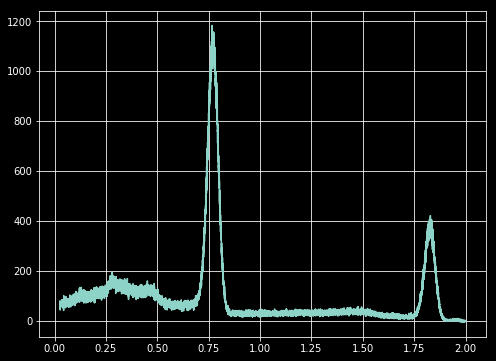

In [428]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(dat_sub_Na309['freq'],dat_sub_Na309['vals'])
ax.grid()

In [429]:
#Peak 1
#plot data and find the optimal range
up_lim = 0.9
low_lim = 0.6
p0 = [0.77,0.01,1000,0,0]
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Na309
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,datx,daty,p0 = p0)
Na21_paras, Na21_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(0.6, 0.9)

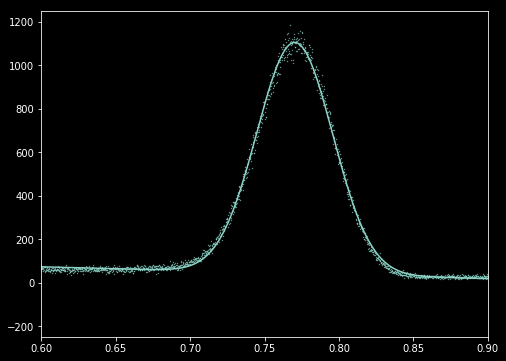

In [430]:
datass = dat_sub_Na309
parass = Na21_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

In [431]:
#Peak 2
#plot data and find the optimal range
up_lim = 1.9
low_lim = 1.725
p0 = [1.825,0.01,500,0,0]
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Na309
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,datx,daty,p0 = p0)
Na22_paras, Na22_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(1.725, 1.9)

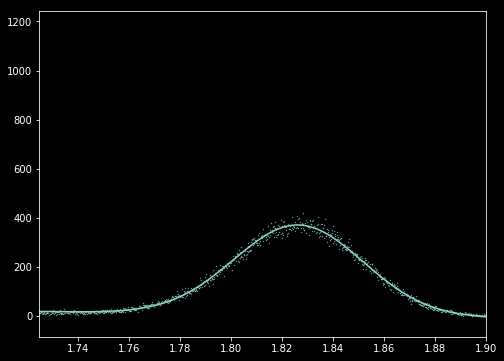

In [432]:
datass = dat_sub_Na309
parass = Na22_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

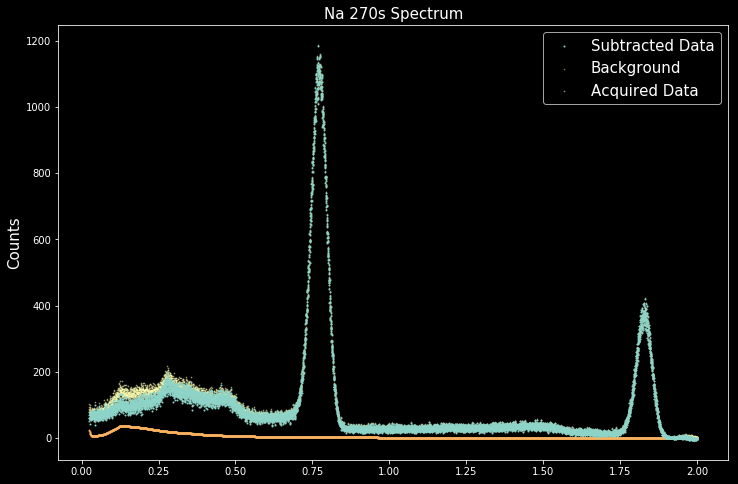

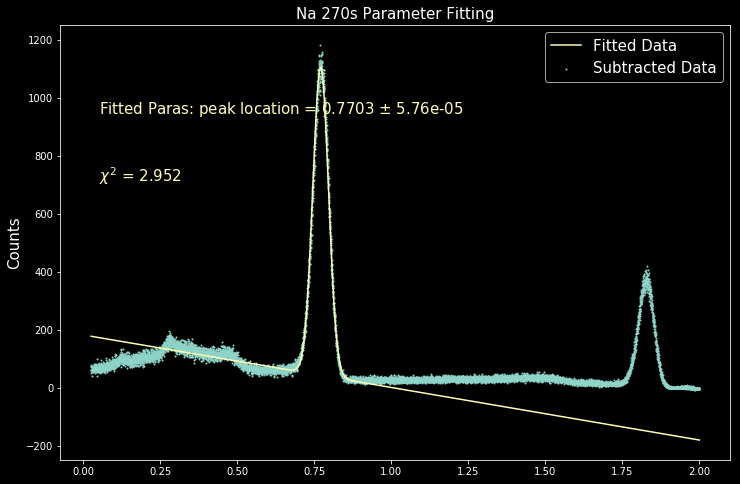

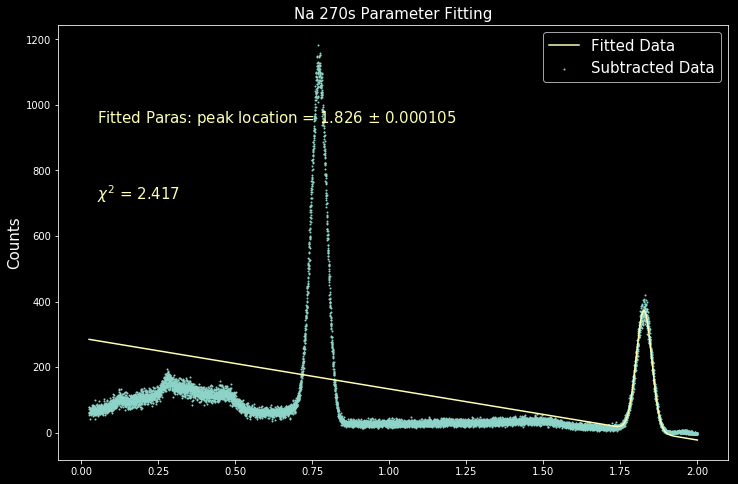

In [433]:
plot_bg(dat_sub_Na309, data,'Na 270s Spectrum',t=286/60)
plot_fit(dat_sub_Na309, Na21_paras,Na21_errs,'Na 270s Parameter Fitting')
plot_fit(dat_sub_Na309, Na22_paras,Na22_errs,'Na 270s Parameter Fitting')

In [434]:
#Extract peak location from the given fits
#Average (peak x location)

result = []
err = []

result += [[0.511,Na11_paras[0]]]
err += [[0.511,Na11_errs[0]]]
result += [[0.511,Na21_paras[0]]]
err += [[0.511,Na21_errs[0]]]

result += [[1.28,Na12_paras[0]]]
err += [[1.28,Na12_errs[0]]]
result += [[1.28,Na22_paras[0]]]
err += [[1.28,Na22_errs[0]]]

result += [[0.6616,Cs11_paras[0]]]
err += [[0.6616,Cs11_errs[0]]]

result +=

result += [[1.17,Co11_paras[0]]]
err += [[1.17,Co11_errs[0]]]



result += [[1.33,Co12_paras[0]]]
err += [[1.33,Co12_errs[0]]]

result += [[0.84,Mn11_paras[0]]]
err += [[0.84,Mn11_errs[0]]]


In [217]:
err

[[0.511, 6.016505955482929e-05],
 [0.511, 5.698669094120394e-05],
 [1.28, 9.778470289272975e-05],
 [1.28, 0.00010616590689930156],
 [0.6616, 6.96008760431362e-05],
 [1.17, 0.00010173861828372334],
 [1.33, 8.722745330301902e-05],
 [0.84, 4.061364533909752e-06]]

In [218]:
result

[[0.511, 0.7706685048468789],
 [0.511, 0.7702738102851218],
 [1.28, 1.827781730060231],
 [1.28, 1.8264655699420524],
 [0.6616, 0.9909466790577333],
 [1.17, 1.7326275951833872],
 [1.33, 1.871573370348027],
 [0.84, 1.2614904957379705]]

In [219]:
Na11_errs

[6.016505955482929e-05,
 5.8780167797213586e-05,
 2.3480544659908262,
 3.3896828424807035,
 2.7928582741869707]

In [221]:
np.array(err)

array([[5.11000000e-01, 6.01650596e-05],
       [5.11000000e-01, 5.69866909e-05],
       [1.28000000e+00, 9.77847029e-05],
       [1.28000000e+00, 1.06165907e-04],
       [6.61600000e-01, 6.96008760e-05],
       [1.17000000e+00, 1.01738618e-04],
       [1.33000000e+00, 8.72274533e-05],
       [8.40000000e-01, 4.06136453e-06]])

In [648]:
def linear(x,a,b,):
    return(a*x+b)
xdata = np.array(result)[:, 0]
ydata = np.array(result)[:, 1]
yerr = np.array(err)[:, 1]
# optimize.curve_fit(linear, xdata, ydata)

In [673]:
def quad(x,a,b,c):
    return(a*x**2+b*x+c)

In [688]:
def mt_fit_simple(func,data_x,data_y,err_x ,err_y,N):
    
    parass = []
    errss = []
    for i in range(N):
#         data_xe = np.array(data_x)+np.random.normal(0,err_x)
#         data_ye = np.array(data_y)+np.random.normal(0,err_y)

        data_xe = np.random.normal(data_x,err_x)
        data_ye = np.random.normal(data_y,err_y)
#         print(data_ye)

        paras, errs = optimize.curve_fit(func, data_xe, data_ye,)
#         print(parass)
        parass += [paras]
        errss += [errs]
        
    return (np.array(parass), np.array(errss))

In [689]:
xdata

array([0.511 , 0.511 , 1.28  , 1.28  , 0.6616, 1.17  , 1.33  , 0.84  ])

In [690]:
parass, errss = mt_fit_simple(linear,xdata,ydata,0.0,yerr,1000)

In [680]:
parass, errss = mt_fit_simple(quad,xdata,ydata,0.0,yerr,1000)

array([6.05335008e-05, 5.76227821e-05, 1.01344631e-04, 1.05129222e-04,
       6.89357830e-05, 9.89547899e-05, 8.49918840e-05, 4.03821837e-06])

In [691]:
slope = np.mean(parass[:,0])
slope_err = np.std(parass[:,0])

# slope0 = np.mean(parass[:,2])
# slope_err0 = np.std(parass[:,2])

intercept = np.mean(parass[:,1])
intercept_err = np.std(parass[:,1])

Text(0.5, 0, 'Energies of Gamma Ray Particles')

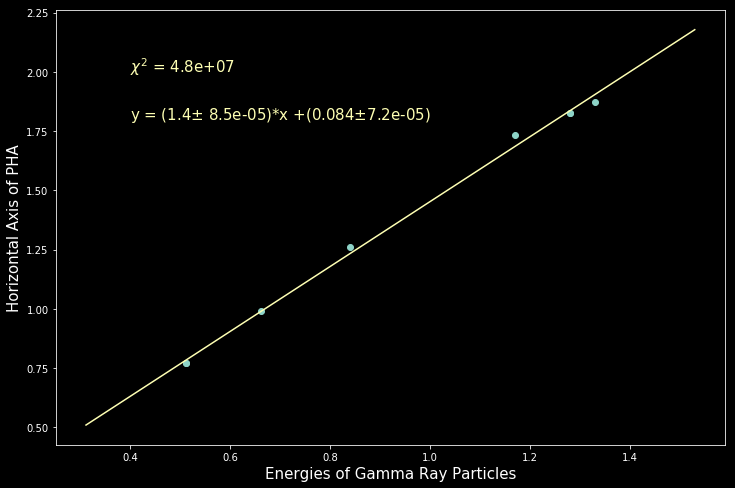

In [699]:
fig,ax = plt.subplots(figsize = (12,8))

plt.scatter(np.array(result)[:, 0],np.array(result)[:, 1],)
ax.errorbar(np.array(result)[:, 0],np.array(result)[:, 1],np.array(err)[:, 1],ls = 'none')
xx = np.linspace(min(np.array(result)[:,0]-0.2),max(np.array(result)[:,0]+0.2),20)
plt.plot(xx,(linear(xx,slope,intercept)),color = color[1])

chi = chisquared(np.array(result)[:, 1],linear(np.array(result)[:, 0],slope,intercept),yerr)

ax.text(0.4,2,r"$\chi^2$ = {:.2g}".format(chi),color = color[1],fontsize = 15)
ax.text(0.4,1.8,r"y = ({a:.2g}$\pm$ {c:.2g})*x +({b:.2g}$\pm${d:.2g})".format(a = slope,b = intercept,
                                                                              c = slope_err,d = intercept_err),
        color = color[1],fontsize = 15)

ax.set_ylabel('Horizontal Axis of PHA',fontsize = 15)
ax.set_xlabel('Energies of Gamma Ray Particles',fontsize = 15)

In [693]:
chi

47691731.915626615